#### <b>Summary</b>
##### In this notebook, I want to understand and get a baseline of how closely extractive summaries align with abstracts of papers. I use [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf), an unsupervised algorithm that identifies important sentences from text to predict extractive summaries of papers and Rouge score to evaluate the summaries.

#### <b>Observations</b>
##### Some papers do not contain an abstract and/or bodytext whereas some have non-english language. I remove these papers from the corpus since they'll affect the ouput of the TextRank model. 

##### I observed that the model failed to predict summaries for papers that have less than 100 words in abstracts. This is because I asked the model to predict a summary of length equal to abstract. 
##### Abstracts that have word length less than 100 need to be removed from the corpus as the word length seems too less to have good quality text in it.

##### The mean F-score for Rouge 1/2/L lies within the range of 0.1 - 0.4 with Rouge 1 performing better than the other which suggests there are more 1-gram matches between predicted summaries and abstracts than 2-grams and LCS. 
##### There are papers with really high and low rouge scores and on further examining them, those with high rouge scores >0.80 have same text in the abstract as the bodytext. Hence, the high scores. 





In [1]:
import glob
import json
import spacy
import pandas as pd
import random
from rouge import Rouge
from summa import summarizer
from sklearn.model_selection import train_test_split
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np

## Data loading and cleaning
   1. Load papers into a dataframe.
   2. Filter papers without an abstract or body text.
   3. Filter non-english papers.

In [2]:
path = '/home/prajakta/Documents/SharpestMinds/COVID-analysis/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])
filter = (data.abstract != "") & (data.bodytext != "")
data = data[filter]

data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))


data.query('len_bt>=10 and len_ab >=10', inplace = True)

#identify languages of texts to filter out non-english papers
data['bt_lang'] = data.bodytext.map(lambda x: detect(x))
data['ab_lang'] = data.abstract.map(lambda x: detect(x))

#use only english papers
data = data[(data['bt_lang'] == 'en') & (data['ab_lang'] == 'en')]

x = data.drop('abstract', axis = 1)
y = data.abstract


#### Dataset size after cleaning and filtering  = 8700

In [3]:
data.shape

(8702, 7)

#### Apply TextRank algorithm to generate extractive summaries on the most important sentences from body text of a paper. The length of the predicted summaries is limited to the length of the abstracts

In [4]:
#%%timeit
data["textrank_summary"]=data.apply(lambda x: summarizer.summarize(str(x.bodytext), words = x.len_ab), axis = 1)
data[:2]

,paper_id,bodytext,abstract,len_bt,len_ab,bt_lang,ab_lang,textrank_summary
0,17413f651645c2b9c92555e9ce1404b9290eccab,a1111111111 a1111111111 a1111111111 a11111111...,"The cellular serine protease TMPRSS2, a membe...",3544,267,en,en,"Moreover, we demonstrate that spread of FLUAV ..."
3,ab8c1e32b66b02cd703799df3d2ee37a1cb369b7,Middle East respiratory syndrome coronavirus ...,The persistent public health threat of infect...,4250,224,en,en,The current study determined the effects of a ...


### Calculate and plot Rouge scores for predicted summaries and abstracts

### Observations
1. Looking at the plots, the mean F-score for Rouge 1/2/L lies within the range of 0.1 - 0.4 with Rouge 1 performing better than the other which suggests there are more 1-gram matches between predicted summaries and abstracts than 2-grams and LCS. 
2. There are papers with really high Rouge scores and low rouge scores.
3. Papers with high rouge scores >0.80 have same text as the bodytext. Hence, the high scores. 
4. Abstracts that have word length less than 100 may need to be removed from corpus as the word length seems too less to have good quality text in it.

In [5]:
def cal_rougescore(row,metric, measure):
    if row.textrank_summary == "":
        return 0
    else:
        return evaluator.get_scores(str(row.textrank_summary), str(row.abstract))[0][metric][measure]

In [6]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'f'), axis = 1)
data["rouge_2_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'f'), axis = 1)
data["rouge_l_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'f'), axis = 1)

data["rouge_1_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'p'), axis = 1)
data["rouge_2_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'p'), axis = 1)
data["rouge_l_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'p'), axis = 1)

data["rouge_1_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'r'), axis = 1)
data["rouge_2_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'r'), axis = 1)
data["rouge_l_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'r'), axis = 1)

Text(0.5, 0, 'abstract length')

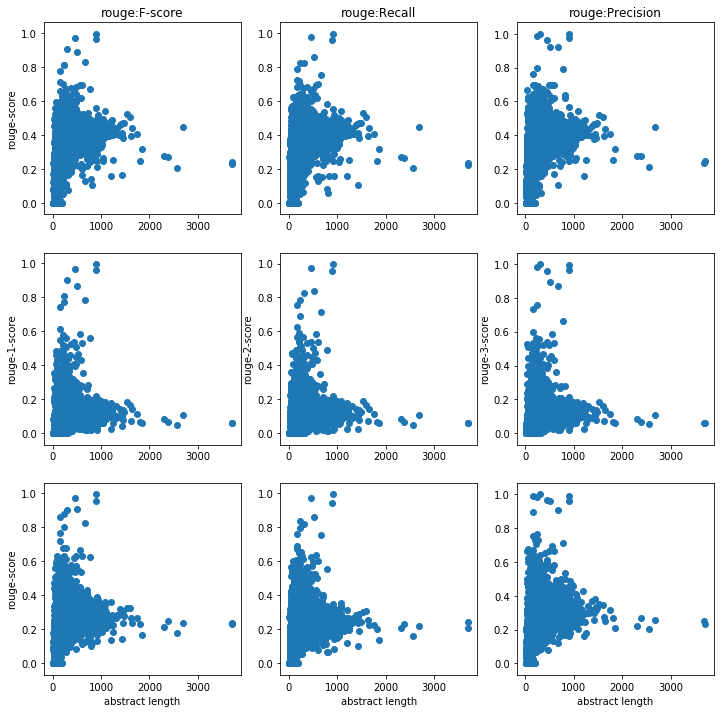

In [7]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(data.len_ab, data.rouge_1_f)
#plt.line(data.length_abstract, np.mean(data.rouge_1_f), linestyle = '--')
plt.title('rouge:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(data.len_ab, data.rouge_1_r)
plt.title('rouge:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(data.len_ab, data.rouge_1_p)
plt.title('rouge:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(data.len_ab, data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-1-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(data.len_ab, data.rouge_2_r)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-2-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(data.len_ab, data.rouge_2_p)
#plt.title('rouge-3:F-score')
plt.ylabel('rouge-3-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(data.len_ab, data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(data.len_ab, data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(data.len_ab, data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')


#### About 25% of papers have text length less than 175 words. These could be ignored as the word length is too low to contain good information.

In [8]:
data.len_ab.describe()

count    8702.000000
mean      260.540910
std       176.815542
min        10.000000
25%       177.000000
50%       231.000000
75%       296.000000
max      3706.000000
Name: len_ab, dtype: float64

#### Clean the dataset by removing abstracts with text length < 50

In [9]:
clean_data = data[data.len_ab > 100]
clean_data.shape

(8131, 17)

#### Explore Rouge scores with the cleaned dataset

Text(0.5, 0, 'abstract length')

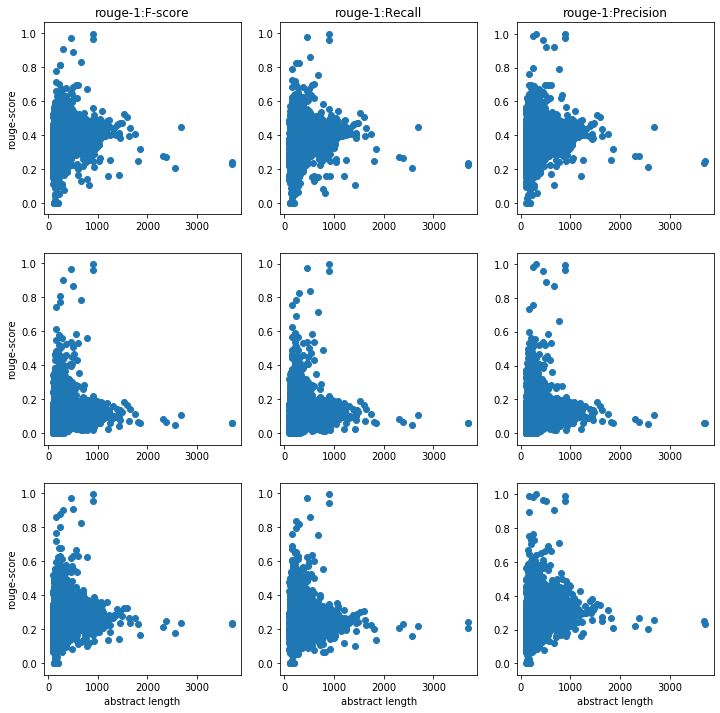

In [10]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(clean_data.len_ab, clean_data.rouge_1_f)
#plt.line(clean_data.length_abstract, np.mean(clean_data.rouge_1_f), linestyle = '--')
plt.title('rouge-1:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(clean_data.len_ab, clean_data.rouge_1_r)
plt.title('rouge-1:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(clean_data.len_ab, clean_data.rouge_1_p)
plt.title('rouge-1:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(clean_data.len_ab, clean_data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(clean_data.len_ab, clean_data.rouge_2_r)
#plt.title('rouge-2:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(clean_data.len_ab, clean_data.rouge_2_p)
#plt.title('rouge-3:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(clean_data.len_ab, clean_data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(clean_data.len_ab, clean_data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(clean_data.len_ab, clean_data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

#### TextRank algorithm failed to predict summaries for 79 papers. This is probably because they all have length of abstracts < 100. 

In [11]:
data[data.textrank_summary == ""].count()

paper_id            79
bodytext            79
abstract            79
len_bt              79
len_ab              79
bt_lang             79
ab_lang             79
textrank_summary    79
rouge_1_f           79
rouge_2_f           79
rouge_l_f           79
rouge_1_p           79
rouge_2_p           79
rouge_l_p           79
rouge_1_r           79
rouge_2_r           79
rouge_l_r           79
dtype: int64

#### The mean Rouge-1 F-score is 0.37

In [12]:
data.rouge_1_f.describe()

count    8702.000000
mean        0.373571
std         0.096505
min         0.000000
25%         0.319255
50%         0.381708
75%         0.435208
max         0.997227
Name: rouge_1_f, dtype: float64